# Scenario 2.4 - Model Building
We are going to train a model that will predict, for a given target, the activity of an input molecule (identified by its Morgan fingerprint). The data used to train our model will be found in PPPlus. In order to create our experiment data set, we will need to find, for each study in PPPlus:

* the Smiles of the drug used in this study,
* the the targets of that drug,
* the activity of that drug on its targets

# Extracting Data

We will start by specifying the paths to the different tables of PPPlus that are of interest to us in order to reach this information. 

In [1]:
# Setting up the paths to each required table
hdfs_path = "hdfs://demo-full-load-hdfs-namenode:8020"
pp_drug_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-drug_deduplicated/*.csv'
pp_study_design_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-studydesign_deduplicated/*.csv'
pp_study_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-study_deduplicated/*.csv'
pp_result_path =  hdfs_path + '/ppplus/elsevier-csv-ppplus-result_deduplicated/*.csv'
pp_measure_path =  hdfs_path + '/ppplus/elsevier-csv-ppplus-measure_deduplicated/*.csv'
pp_dosing_regimen = hdfs_path + '/ppplus/elsevier-csv-ppplus-dosingregimen_deduplicated/*.csv'
pp_target_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-target_deduplicated/*.csv'

Once the paths are specified, we start a Spark session in order to be able to open the corresponding csv files stored in hdfs.

In [2]:
#  import spark related modules
import pyspark
import socket
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct
from pyspark import SparkContext, StorageLevel
from rdkit.Chem.Draw.IPythonConsole import display_pil_image
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem.Draw import MolsToGridImage
from rdkit import Chem
import os , sys
import multiprocessing as mp
import uuid

def add_prefix(sdf, prefix):
    for c in sdf.columns:
        sdf = sdf.withColumnRenamed(c, '{}{}'.format(prefix, c))
    return sdf

# prevent error on rerunning if session is still alive
if 'sc' in globals():
    sc.stop()
    
# most configuration of the sparksession is done for you in the back
application_name = 'Use case 1 - Pharmapendium'

conf = pyspark.SparkConf()\
    .set("spark.driver.memory","10g")\
    .set("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .set("spark.sql.crossJoin.enabled", "true")\
    .set("spark.sql.shuffle.partitions" , 16)\
    .setAppName(application_name).setMaster('local[*]')

sparkSession = SparkSession.builder.appName('job_name')\
                           .config('spark.executor.memory', '4g')\
                           .config('spark.executor.instances', '5')\
                           .config('spark.sql.shuffle.partitions', '50')\
                           .config('spark.driver.memory', '4g')\
                           .config('spark.executor.cores', '3')\
                           .config('spark.driver.host', socket.gethostbyname(socket.gethostname()))\
                           .getOrCreate()

#sparkSession = SparkSession.builder.config(conf=conf).getOrCreate()

sc = sparkSession.sparkContext
sc

<SparkContext master=k8s://https://kubernetes.default.svc.cluster.local:443 appName=job_name>

We will now create a Spark dataframe for each table, containing the columns that will be needed to retrieve the information that we need.

In [3]:
import pprint
from IPython.display import Markdown, display, HTML

ppplus_drug = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_drug_path) \
            .select(["Drug","hasName","hasSmiles"]) \
            .withColumnRenamed('hasName','drugName') \
            .dropDuplicates(['Drug'])
drug = ppplus_drug.alias('drug')

ppplus_target = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_target_path) \
            .select(["Target","core_prefLabel"]) \
            .withColumnRenamed('core_prefLabel','targetName') \
            .dropDuplicates(['Target'])
targets = ppplus_target.alias('targets')

pp_study_design = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_study_design_path) \
            .select(["StudyDesign","hasTarget","hasAgonistAntagonist"])\
            .dropDuplicates(['StudyDesign'])\
            .na.drop(subset=["hasAgonistAntagonist"])
study_design = pp_study_design.alias('study_design')

pp_study = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_study_path) \
            .select(["Study","hasStudyDesign","hasDosingRegimen","hasMeasure"])\
            .dropDuplicates(['Study'])
study = pp_study.alias('study')

ppplus_result = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_result_path) \
            .select(["Result","hasValue"])\
            .dropDuplicates(['Result'])
results = ppplus_result.alias('results')

ppplus_measure = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_measure_path) \
            .select(["Measure","hasResult","hasParameterDisplay","hasPkParameter"])\
            .dropDuplicates(['Measure'])
measures = ppplus_measure.alias('measures')

ppplus_dosing_regimen = sparkSession \
            .read \
            .option("header","true") \
            .csv(pp_dosing_regimen) \
            .select(["DosingRegimen","hasDrug"])\
            .dropDuplicates(['DosingRegimen'])
dosing_regimen = ppplus_dosing_regimen.alias('dosing_regimen')

Once we have all the tables as dataframes, we can join them together. We start by joining study_design and dosing_regiment to study. From study_design, we can access the *hasAgonistAntagonist* column that qualifies the activity that the study's drug has on its targets. Then, we join drug to study_desing which gives us access to the column *hasSmiles* for every study. The target is a bit trickier to get: the *hasTarget* column of study_design contains a serialized list of target uri, which we will need to separate with the methods split() and explode(). Once done, we have a new row for each different target of the study.

In [4]:
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import concat, lit, col, split, explode

df = study\
     .join(study_design      , study.hasStudyDesign    == study_design.StudyDesign, how='inner')\
     .join(dosing_regimen    , study.hasDosingRegimen  == dosing_regimen.DosingRegimen , how='inner')\
     .join(drug              , dosing_regimen.hasDrug  == drug.Drug , how='inner')\
     .select(split(col("hasTarget"),"\|\|").alias("hasTarget"), "hasAgonistAntagonist", "hasSmiles")\
     .withColumn('hasTarget' , explode('hasTarget'))

With each target uri on a different row, we can join the table with targets. This gives us access to the *targetName* column, containing the name of the target.

In [5]:
df2 = df.join(targets           , df.hasTarget == targets.Target, how='inner')

From this point, we decide to use D4 Dopamine Receptor as out target, meaning that our model will be able to give a prediction of the activity that any input molecule has on D4 dopamine Receptors. We also decide to not predict the activities labeled as not applicable.

In [6]:
focused_target = sc.broadcast(["D4 Dopamine Receptor"])
focused_activity = sc.broadcast(["Not applicable"])
result = df2.where(targets.targetName.isin(focused_target.value)\
                & ~study_design.hasAgonistAntagonist.isin(focused_activity.value))

We obtain a dataframe containing all the raw information that is needed to train our model. We get a quick view into it:

In [7]:
display(result.limit(10).toPandas())

,hasTarget,hasAgonistAntagonist,hasSmiles,Target,targetName
0,https://data.elsevier.com/lifescience/taxonomy...,Radioligand (/ligand),ClC1=CC=CC(N2CCN(CCCCOC3=CC=C4CCC(=O)NC4=C3)CC...,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
1,https://data.elsevier.com/lifescience/taxonomy...,Radioligand (/ligand),ClC1=CC=CC(N2CCN(CCCCOC3=CC=C4CCC(=O)NC4=C3)CC...,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
2,https://data.elsevier.com/lifescience/taxonomy...,Inhibitor,CCCCCCCCCC(=O)OCCN1CCN(CCCN2C3=CC(=CC=C3SC3=C2...,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
3,https://data.elsevier.com/lifescience/taxonomy...,Inhibitor,CCCCCCCCCC(=O)OCCN1CCN(CCCN2C3=CC(=CC=C3SC3=C2...,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
4,https://data.elsevier.com/lifescience/taxonomy...,Agonist,Cl.NCCC1=CC=C(O)C(O)=C1,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
5,https://data.elsevier.com/lifescience/taxonomy...,Agonist,Cl.NCCC1=CC=C(O)C(O)=C1,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
6,https://data.elsevier.com/lifescience/taxonomy...,Radioligand (/ligand),OC1(CCN(CCCC(=O)C2=CC=C(F)C=C2)CC1)C1=CC=C(Cl)...,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
7,https://data.elsevier.com/lifescience/taxonomy...,Radioligand (/ligand),OC1(CCN(CCCC(=O)C2=CC=C(F)C=C2)CC1)C1=CC=C(Cl)...,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
8,https://data.elsevier.com/lifescience/taxonomy...,Agonist,Cl.CCCN(CCC)CCC1=CC=CC2=C1CC(=O)N2,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
9,https://data.elsevier.com/lifescience/taxonomy...,Agonist,Cl.CCCN(CCC)CCC1=CC=CC2=C1CC(=O)N2,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor


In [8]:
result.groupBy('hasAgonistAntagonist').count().show()

+--------------------+-----+
|hasAgonistAntagonist|count|
+--------------------+-----+
|Allosteric Modulator|   12|
|             Agonist| 2176|
|     Inverse agonist|  166|
|             Blocker|  624|
|Radioligand (/lig...|  172|
|          Antagonist|  978|
|           Inhibitor|  562|
|          Stimulator|   54|
|           Activator|   62|
|           Substrate|   26|
+--------------------+-----+



We can now save that data into a csv file in order to be able to re-open in later without doing the same data processing.

In [9]:
result.toPandas().to_csv('database_target_activity.csv')

After restarting a session, it is possible to continue from this point.

In [10]:
import pandas as pd
data = pd.read_csv("database_target_activity.csv")
display(data)

,Unnamed: 0,hasTarget,hasAgonistAntagonist,hasSmiles,Target,targetName
0,0,https://data.elsevier.com/lifescience/taxonomy...,Radioligand (/ligand),ClC1=CC=CC(N2CCN(CCCCOC3=CC=C4CCC(=O)NC4=C3)CC...,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
1,1,https://data.elsevier.com/lifescience/taxonomy...,Radioligand (/ligand),ClC1=CC=CC(N2CCN(CCCCOC3=CC=C4CCC(=O)NC4=C3)CC...,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
2,2,https://data.elsevier.com/lifescience/taxonomy...,Inhibitor,CCCCCCCCCC(=O)OCCN1CCN(CCCN2C3=CC(=CC=C3SC3=C2...,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
3,3,https://data.elsevier.com/lifescience/taxonomy...,Inhibitor,CCCCCCCCCC(=O)OCCN1CCN(CCCN2C3=CC(=CC=C3SC3=C2...,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
4,4,https://data.elsevier.com/lifescience/taxonomy...,Agonist,Cl.NCCC1=CC=C(O)C(O)=C1,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
...,...,...,...,...,...,...
4827,4827,https://data.elsevier.com/lifescience/taxonomy...,Agonist,OC1(CCN(CCCC(=O)C2=CC=C(F)C=C2)CC1)C1=CC=C(Cl)...,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
4828,4828,https://data.elsevier.com/lifescience/taxonomy...,Agonist,Cl.NCCC1=CC=C(O)C(O)=C1,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
4829,4829,https://data.elsevier.com/lifescience/taxonomy...,Agonist,Cl.NCCC1=CC=C(O)C(O)=C1,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor
4830,4830,https://data.elsevier.com/lifescience/taxonomy...,Antagonist,Cl.CN(C)CCCN1C2=CC(Cl)=CC=C2SC2=C1C=CC=C2,https://data.elsevier.com/lifescience/taxonomy...,D4 Dopamine Receptor


We have the Smiles of our drugs, but the input of our model will be the Morgan fingerprints. In order to obtain the Morgan fingerprints from the Smiles, we will use the RDKit module. With it, we create a function that transforms a Smiles into an array of ones and zeros representing the Morgan Fingerprint of the molecule.

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

def to_morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=512)
    arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr

Regarding the output of our model, we currently have a string that qualifies the activity of our drug on the target ("Agonist" for instance). We need to vectorize our output in order to train the model (MLP) that we will use. In order to do so, we define another function. 

In [12]:
def vectorize(value):
    return [1 if i == value else 0 for i in data.hasAgonistAntagonist.unique()]

With our two functions, we create two new columns in the dataframe: one with the fingerprints and another with the vectorized activity.

In [13]:
import numpy as np
data['Fingerprint'] = data["hasSmiles"].apply(to_morgan_fp)

In [14]:
data['Activity'] = data["hasAgonistAntagonist"].apply(vectorize)

We can take a look at the result:

In [15]:
data_set = data[["Fingerprint","Activity"]]
display(data_set)

,Fingerprint,Activity
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
4827,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4828,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4829,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4830,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


This initial dataset is separated into a training set and a test set.

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_set)

train_x = train["Fingerprint"]
test_x = test["Fingerprint"]
train_y = train["Activity"]
test_y = test["Activity"]

# Training the Model

It is now time to train our Multi-Layer Perceptron (MLP) on the training data. We use the MLP model provided by the scikit learn module.

In [17]:
from sklearn.neural_network import MLPClassifier
from rdkit.DataStructs.cDataStructs import BitVectToBinaryText
import numpy as np
X = [train_x.to_numpy()[i] for i in range(len(train_x))][0:2]
y = [i for i in train_y][0:2]
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X, y)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

We can now use our trained model to make predictions on new molecules' activities.

In [18]:
t_x = test_x.to_numpy()[0]
t_y = test_y.to_numpy()[0]
result = clf.predict([t_x])

In [19]:
def vec_to_activity(vec):
    out = []
    for i in range(len(vec)):
        if vec[i] == 1:
            out.append(data.hasAgonistAntagonist.unique()[i])
    return out

print(vec_to_activity(result[0]))

['Radioligand (/ligand)']


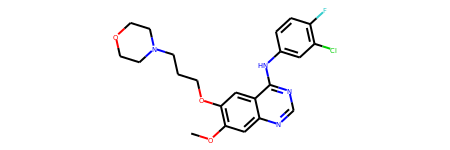

In [20]:
gefitinib = 'COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4'
Chem.MolFromSmiles(gefitinib)

In [42]:
result = clf.predict([my_mp])
print(vec_to_activity(result[0]))

['Inhibitor']
